In [36]:
#setup
from IPython.display import display
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import copy
import gensim

sns.set_theme()
plt.rcParams["figure.figsize"] = (10,8)
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [37]:
from main import nlp_pipeline_result

In [5]:
# #data_ner = nlp_pipeline_result(disable_ner = False)
# #data.to_csv('data/data_ner.csv')

#data_non_ner = nlp_pipeline_result()
#data_non_ner['n_lemmas'] = data_non_ner['Lemmas'].str.split().str.len()

# #data_non_ner.to_csv('data/data.csv',index = False)

In [104]:
data = pd.read_csv('data/data.csv')

In [44]:
#for i in range(0,50,10):
 # display(data[i:i+10])

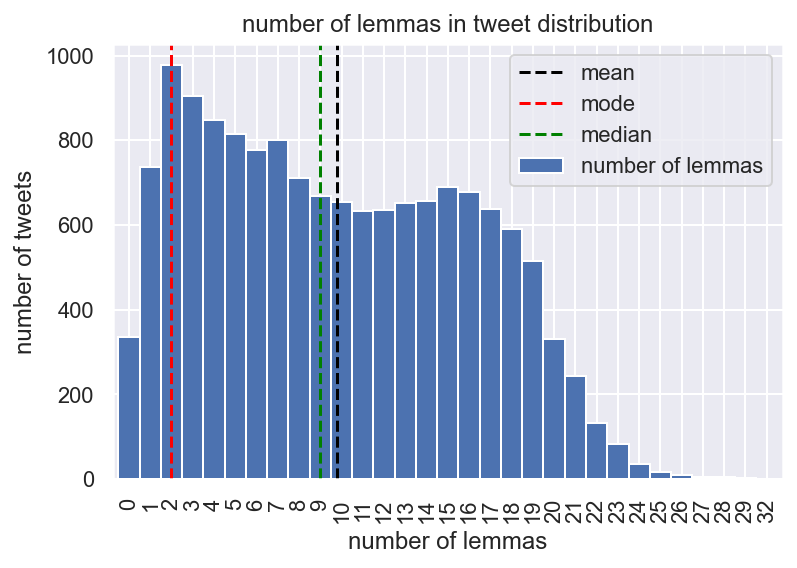

In [88]:
plt.figure()
data['n_lemmas'].value_counts().sort_index().plot(kind="bar",width=1,label='number of lemmas')
plt.axvline(x = data['n_lemmas'].mean(),label='mean',color = 'black',linestyle = '--')
plt.axvline(x = data['n_lemmas'].mode()[0],label='mode',color = 'red',linestyle = '--')
plt.axvline(x = data['n_lemmas'].median(),label='median',color = 'green',linestyle = '--')
plt.legend()
plt.title('number of lemmas in tweet distribution')
plt.xlabel('number of lemmas')
plt.ylabel('number of tweets')
plt.show()

In [106]:
data = data[data['n_lemmas']>=3]
print('Number of tweets in DataFrame after removing short tweets:', len(data))

Number of tweets in DataFrame after removing short tweets: 12733


In [111]:
tweets_corpus = data["Lemmas"].tolist()
tweets_corpus = list(set(tweets_corpus))
tweets_corpus = [el.split() for el in tweets_corpus]

# display(tweets_corpus)

In [112]:
gensim.corpora.dictionary

<module 'gensim.corpora.dictionary' from 'd:\\universidad\\projects\\nlp-with-spanish-politicians-tweets\\venv\\lib\\site-packages\\gensim\\corpora\\dictionary.py'>

In [113]:
token_dic = gensim.corpora.Dictionary(tweets_corpus)

# Filter token dictionary

no_below = 5  # Minimum number of documents to keep a term in the dictionary
no_above = .4  # Maximum proportion of documents in which a term can appear to be kept in the dictionary


# BOW: Transform list of tokens into list of tuples (token id, token # of occurrences)

tweets_corpus_bow = [token_dic.doc2bow(doc) for doc in tweets_corpus]

tweets_corpus_bow

[[(0, 1),
  (1, 1),
  (2, 1),
  (3, 1),
  (4, 1),
  (5, 1),
  (6, 1),
  (7, 1),
  (8, 1),
  (9, 1),
  (10, 5),
  (11, 1),
  (12, 5),
  (13, 1)],
 [(14, 1), (15, 1), (16, 1)],
 [(17, 2),
  (18, 1),
  (19, 2),
  (20, 1),
  (21, 1),
  (22, 1),
  (23, 1),
  (24, 1),
  (25, 1),
  (26, 1)],
 [(27, 1),
  (28, 1),
  (29, 1),
  (30, 1),
  (31, 1),
  (32, 1),
  (33, 1),
  (34, 1),
  (35, 1),
  (36, 1),
  (37, 1),
  (38, 1),
  (39, 1)],
 [(40, 1),
  (41, 1),
  (42, 1),
  (43, 1),
  (44, 1),
  (45, 1),
  (46, 1),
  (47, 1),
  (48, 1)],
 [(2, 1),
  (44, 1),
  (49, 1),
  (50, 1),
  (51, 1),
  (52, 1),
  (53, 1),
  (54, 1),
  (55, 1),
  (56, 1),
  (57, 1),
  (58, 1),
  (59, 1)],
 [(60, 1), (61, 1), (62, 1)],
 [(2, 1),
  (63, 1),
  (64, 1),
  (65, 1),
  (66, 2),
  (67, 1),
  (68, 1),
  (69, 1),
  (70, 1),
  (71, 1),
  (72, 1),
  (73, 1),
  (74, 1),
  (75, 1),
  (76, 1)],
 [(16, 1), (77, 1), (78, 1), (79, 1)],
 [(80, 1), (81, 1), (82, 1), (83, 1), (84, 1), (85, 1)],
 [(86, 1),
  (87, 1),
  (88, 1),
  (

In [34]:
from gensim.models.wrappers import LdaMallet
import os

#os.environ['MALLET_HOME'] = 'mallet-2.0.8'
mallet_path = 'mallet-2.0.8/bin/mallet'

ldamallet = LdaMallet(mallet_path, corpus=tweets_corpus_bow, num_topics=20, id2word=token_dic, alpha=5, iterations=100)

CalledProcessError: Command 'mallet-2.0.8/bin/mallet import-file --preserve-case --keep-sequence --remove-stopwords --token-regex "\S+" --input C:\Users\chave\AppData\Local\Temp\fdcc3b_corpus.txt --output C:\Users\chave\AppData\Local\Temp\fdcc3b_corpus.mallet' returned non-zero exit status 1.